# Training and Deployment of classification of dog images
- This notebook defines the pipeline for training and deploying a model to classify dog breeds in images using AWS SageMaker. 
- The model is based on the ResNet50 model and adds a classifier fully connected neural network to the end of the model. This model is fine tuned to improve accuracy.  
- Hyperparameter searches yield the hyperparameters with the best classification accuracy. 
- Profiling is used to help debug the training job.
- Model is then deployed and its accuracy is tested with randomly selected test images.

## Package installation

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
# Install AWS CLI to download file
!pip install awscli

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 125.9 MB/s eta 0:00:00
Using cached docutils-0.16-py2.py3-none-any.whl (548 kB)
Using cached rsa-4.7.2-py3-none-any

In [66]:
# package loading
import sagemaker
import boto3
import os
import pandas as pd
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule, 
    rule_configs,
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
)
from sagemaker.pytorch import PyTorch
from sagemaker.predictor import Predictor
import random
import io
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import json
from sagemaker.pytorch import PyTorchModel
import IPython
import numpy as np
import matplotlib.pyplot as plt

## Load Dataset
Dataset is the dog classification dataset available at ... 
It contains 133 classes of images of different dog breeds. 

In [79]:
# Use AWS CLI to download the file
!aws s3 cp s3://jm-dog-project-bucket/dogImages.zip . --region us-east-1
!unzip dogImages.zip


download: s3://jm-dog-project-bucket/dogImages.zip to ./dogImages.zip
Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [4]:
# explore dataset
list_of_test_classes = os.listdir('./dogImages/test')
list_of_train_classes = os.listdir('./dogImages/train')
list_of_validate_classes = os.listdir('./dogImages/valid')

number_of_test_classes = len(list_of_test_classes)
number_of_train_classes = len(list_of_train_classes)
number_of_validate_classes = len(list_of_validate_classes)

print(f'Number of train classes: {number_of_train_classes}, number of test classes: {number_of_test_classes}, number of validate classes: {number_of_validate_classes}')

Number of train classes: 133, number of test classes: 133, number of validate classes: 133


## Hyperparameter Tuning
Hyperparameters chosen to tune: 
- lr as in range 0.001 to 0.1. Tested as this is a reasonable range to test without having too severe a learning rate. Optimal value: 0.0014611377532535268
- batch-size between 32, 64, 128. Range of values as balance between accuracy and speed. Optimal value: 64 
- epochs between 2 and 4. Balance again between accuracy and speed. Optimal value: 3



In [3]:
# defining essentials for sagemaker 
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/ml-udacity-project"

role = sagemaker.get_execution_role()

In [4]:
# checking if data already in s3 bucket
s3 = boto3.client('s3')

def check_s3_path_exists(bucket, prefix):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    return 'Contents' in response

if check_s3_path_exists(bucket, prefix):
    print("Data already exists in S3, no need to upload.")
    inputs = f"s3://{bucket}/{prefix}"
else:
    print("Data not found in S3, proceeding with upload.")
    inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

print("Inputs defined as:", inputs)


Data already exists in S3, no need to upload.
Inputs defined as: s3://sagemaker-us-east-1-846247097515/sagemaker/ml-udacity-project


In [ ]:
# for testing the hpo.py script
#! python3 hpo.py --batch-size 64 --epochs 2 --lr 0.01 --data-path "./dogImages/" 

In [34]:
#Declare  HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(2, 4)
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [35]:
#Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'dog-breed-classification',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [37]:
# Fit your HP Tuner
tuner.fit(inputs, wait = True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [38]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-11-11 12:27:33 Starting - Preparing the instances for training
2024-11-11 12:27:33 Downloading - Downloading the training image
2024-11-11 12:27:33 Training - Training image download completed. Training in progress.
2024-11-11 12:27:33 Uploading - Uploading generated training model
2024-11-11 12:27:33 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"64"',
 'epochs': '3',
 'lr': '0.0014611377532535268',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-2024-11-11-11-02-46-302"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-846247097515/dog-breed-classification-2024-11-11-11-02-46-302/source/sourcedir.tar.gz"'}

In [41]:
tuner.best_training_job()

'pytorch-training-241111-1102-001-d659947b'

## Model Profiling and Debugging
Optimal Hyperparameter values: 
- lr = 0.0014611377532535268
- batch-size = 64 
- epochs = 3


Use these to run an individual training job that can be deployed as an endpoint. Debugging and profiling included to help smooth the process. 


In [5]:
# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

training_job_name = 'pytorch-training-241111-1102-001-d659947b'
best_training_job_details = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)


In [6]:
hyperparameters = best_training_job_details['HyperParameters']
role = best_training_job_details['RoleArn']
image_uri = best_training_job_details['AlgorithmSpecification']['TrainingImage']
output_path = best_training_job_details['OutputDataConfig']['S3OutputPath']


In [7]:
for key, value in hyperparameters.items():
    print(key, value)

_tuning_objective_metric Test Loss
batch-size "64"
epochs 3
lr 0.0014611377532535268
sagemaker_container_log_level 20
sagemaker_estimator_class_name "PyTorch"
sagemaker_estimator_module "sagemaker.pytorch.estimator"
sagemaker_job_name "dog-breed-classification-2024-11-11-11-02-46-302"
sagemaker_program "hpo.py"
sagemaker_region "us-east-1"
sagemaker_submit_directory "s3://sagemaker-us-east-1-846247097515/dog-breed-classification-2024-11-11-11-02-46-302/source/sourcedir.tar.gz"


In [10]:
# redefined here to prevent issues in variable types
best_hyperparameters = {
    'batch-size': 64,
     'epochs': 3,
     'lr': 0.0014611377532535268,
}

In [56]:
#20241115 test
# Define debugging and profiling rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing(), #added at request of project reviewer
                   rule_parameters={
                       "tensor_regex": "CrossEntropyLoss_output_0",
                       "mode": "TRAIN"
                   }),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=100, 
    framework_profile_params=FrameworkProfile(start_step=0, num_steps=100)
)

debugger_hook_config = DebuggerHookConfig(
    collection_configs=[
        CollectionConfig(
            name="CrossEntropyLoss_output_0",  
            parameters={
                "include_regex": "CrossEntropyLoss_output_0",
                "train.save_interval": "1",
                "eval.save_interval": "1"
            },
        )
    ]
)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
# check train_model.py with hyperparameters 
#!python3 train_model_4.py --batch-size 64 --epochs 3 --lr 0.0014611377532535268 --data-path './dogImages'

In [57]:
#Create  estimator

estimator = PyTorch(
    entry_point = 'train_model_4.py',
    role = role,
    instance_count=1,
    instance_type = 'ml.p2.xlarge', #changed cos kept crahsing 
    py_version = 'py36',
    framework_version = '1.6',
    hyperparameters = best_hyperparameters,
    debugger_hook_config=debugger_hook_config,
    profiler_config = profiler_config,
    rules=rules
) 



In [58]:
# fit
estimator.fit(inputs, wait = True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framewo

2024-11-15 09:24:17 Starting - Starting the training job...
2024-11-15 09:24:44 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2024-11-15 09:25:44 Downloading - Downloading input data......
2024-11-15 09:26:47 Downloading - Downloading the training image............
2024-11-15 09:28:45 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-11-15 09:29:02,910 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-11-15 09:29:02,937 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-11-15 09:29:02,939 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-11-15 09:29:03,262 sa

In [59]:
# Plot a debugging output.
job_name = estimator._current_job_name
print('Job name:', job_name)


Job name: pytorch-training-2024-11-15-09-24-13-731


In [61]:
from smdebug.trials import create_trial

# Specify the path to the debugging output
trial_path = os.path.join('s3://', bucket, job_name, 'debug-output')

trial = create_trial(trial_path)

# Check available tensors
print("Available Tensors:")
for tensor_name in trial.tensor_names():
    print(tensor_name)

[2024-11-15 09:40:25.787 default:136 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/debug-output
[2024-11-15 09:40:26.177 default:136 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4784 more expected)', IncompleteRead(0 bytes read, 4784 more expected)) while reading s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/debug-output/index/000000000/000000000021_worker_0.json . Will retry now
Available Tensors:
[2024-11-15 09:40:30.050 default:136 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-15 09:40:31.067 default:136 INFO trial.py:210] Loaded all steps
CrossEntropyLoss_output_0
gradient/ResNet_fc.0.bias
gradient/ResNet_fc.0.weight
gradient/ResNet_fc.2.bias
gradient/ResNet_fc.2.weight
layer1.0.relu_input_0
layer1.0.relu_input_1


In [68]:
# Retrieve and print specific tensor values 
loss = []
if 'CrossEntropyLoss_output_0' in trial.tensor_names():
    loss_tensor = trial.tensor('CrossEntropyLoss_output_0')
    for step in loss_tensor.steps():
        loss.append([step, loss_tensor.value(step)])
loss = np.array(loss)

Text(0.5, 0.98, 'Cross Entropy Loss Against Training Steps')

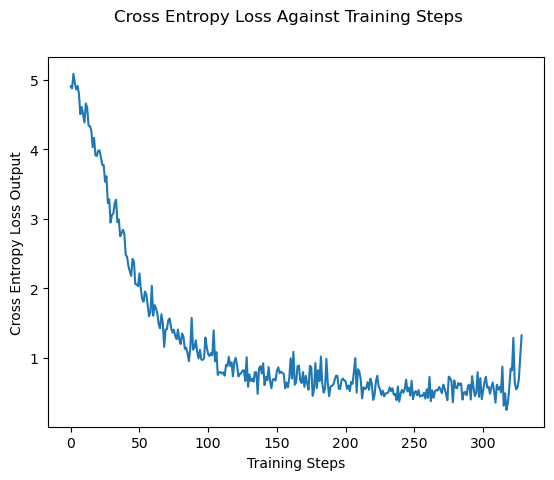

In [72]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1])
ax.set_xlabel('Training Steps')
ax.set_ylabel('Cross Entropy Loss Output')
plt.suptitle('Cross Entropy Loss Against Training Steps')

**Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?**
The loss starts to increase towards the end of the training stage, which may indicate overfitting. Next time, I would reduce the number of epochs to prevent this and stop training before overfitting occurs.


In [74]:
# define and check the path to rule report 
path_for_report = os.path.join('s3://', bucket, job_name, 'rule-output')
print(f'Profiler report location: {path_for_report}')

Profiler report location: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/rule-output


In [75]:
# print files in relevant folder
!aws s3 ls "$path_for_report" --recursive

2024-11-15 09:39:31     398077 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-15 09:39:30     250552 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-15 09:39:25        192 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-15 09:39:25     140148 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-15 09:39:25        126 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-15 09:39:26        327 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-11-15 09:39:26      21621 pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-re

In [76]:
#collect files in relevant folder 
!aws s3 cp "$path_for_report" . --recursive

download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-

In [77]:
#display the debugging report
IPython.display.HTML(filename= './ProfilerReport/profiler-output/profiler-report.html')

## Model Deploying

In [82]:
# Define the root directory containing the image subdirectories
root_dir = './dogImages/test'

# Collect all image file paths in a list
all_image_paths = []
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        # Check if the file is an image
        if file.lower().endswith(('.jpg')):
            all_image_paths.append(os.path.join(dirpath, file))

# Select 10 random images
random_images = random.sample(all_image_paths, 9)


In [83]:
# print images 
for image in random_images: 
    print(image)

./dogImages/test/021.Belgian_sheepdog/Belgian_sheepdog_01488.jpg
./dogImages/test/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04138.jpg
./dogImages/test/088.Irish_water_spaniel/Irish_water_spaniel_05983.jpg
./dogImages/test/069.French_bulldog/French_bulldog_04806.jpg
./dogImages/test/030.Border_terrier/Border_terrier_02090.jpg
./dogImages/test/127.Silky_terrier/Silky_terrier_08040.jpg
./dogImages/test/119.Petit_basset_griffon_vendeen/Petit_basset_griffon_vendeen_07714.jpg
./dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01617.jpg
./dogImages/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00607.jpg


In [84]:
# helper class that facilitates the processing of byte arrays
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class DogImage(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(DogImage, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [85]:
# print model location
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/output/model.tar.gz


In [91]:
# set model location if coming back to a cold session
model_location = 's3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-13-13-13-38-876/output/model.tar.gz'

In [86]:
# define pytorch model to deploy
endpoint_model = PyTorchModel(
    model_data=model_location, 
    role=role, 
    entry_point='endpoint_setup.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=DogImage
)

In [87]:
# Add your deployment configuration like instance type and number of instances
predictor=endpoint_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
) 

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-846247097515/pytorch-training-2024-11-15-09-24-13-731/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-846247097515/pytorch-inference-2024-11-15-09-51-40-970/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-11-15-09-51-50-477
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-11-15-09-51-51-262
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-11-15-09-51-51-262


-------!

Text(0.5, 0.98, 'Predictions against truth for dog predictions')

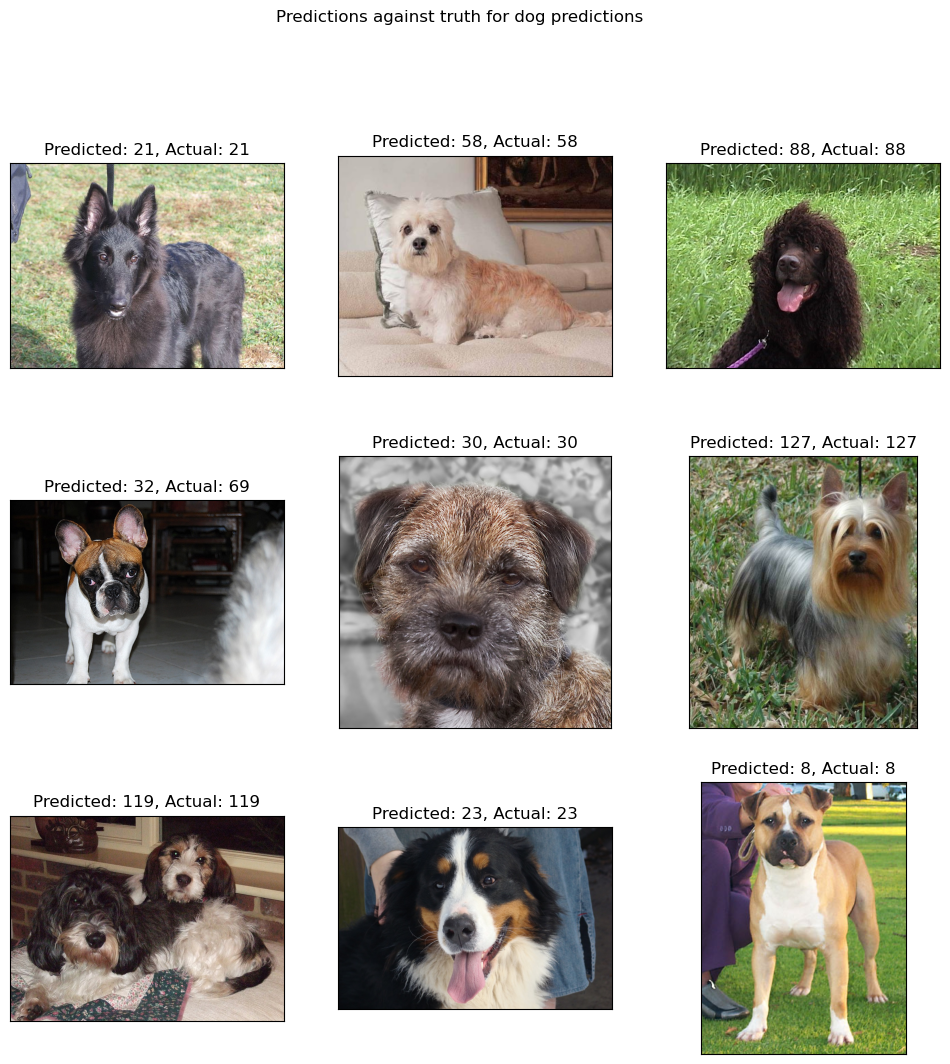

In [94]:
# Deploy your model to an endpoint
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(3,3, figsize = (12,12))
for i, image in enumerate(random_images): 
    #process image to byte array
    with open(image, "rb") as img:
        img_bytes = img.read()
    #query endpoint
    response = predictor.predict(
        img_bytes,
        initial_args={
            "ContentType": "image/jpeg"
        }
    )
    #process response
    predicted = np.argmax(response) +1
    actual = int(image.split('.')[1].split('/')[-1])
    # print with info in title
    ax[i//3, i%3].imshow(Image.open(io.BytesIO(img_bytes)))
    ax[i//3, i%3].set_title(f'Predicted: {predicted}, Actual: {actual}')
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])
plt.suptitle('Predictions against truth for dog predictions')   

In [95]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-11-15-09-51-51-262
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-11-15-09-51-51-262
